# IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas_profiling 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from sklearn.linear_model import SGDClassifier
import statsmodels.api as sm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\CHIWLONG\Anaconda3\lib\site-packages\pandas_profiling\plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\CHIWLONG\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\CHIWLONG\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\CHIWLONG\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\CHIWLONG\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\CHIWLONG\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance()

# READ INITIAL DATASET

In [2]:
# dataset found via Kaggle datasets, since my earlier version didn't have enough useful parameters  
df = pd.read_csv("data\celebrity_deaths_4.csv")

# EDA - CLEANING

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21458 entries, 0 to 21457
Data columns (total 9 columns):
age               21458 non-null int64
birth_year        21458 non-null int64
cause_of_death    8974 non-null object
death_month       21458 non-null object
death_year        21458 non-null int64
famous_for        21440 non-null object
name              21458 non-null object
nationality       21458 non-null object
fame_score        19852 non-null float64
dtypes: float64(1), int64(3), object(5)
memory usage: 1.5+ MB


#### Lots of nulls in the 'cause of death' column and some others that I want to use as parameters. Going to need to trim this down a bit.

In [4]:
# create backup of original dataset
df_backup = df

In [5]:
# only include rows with values for 'famous_for', 'fame_score' and 'cause of death' 
null_cols = ['famous_for', 'fame_score', 'cause_of_death']
for col in null_cols: 
    df = df[df[col].notnull()]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8408 entries, 0 to 21449
Data columns (total 9 columns):
age               8408 non-null int64
birth_year        8408 non-null int64
cause_of_death    8408 non-null object
death_month       8408 non-null object
death_year        8408 non-null int64
famous_for        8408 non-null object
name              8408 non-null object
nationality       8408 non-null object
fame_score        8408 non-null float64
dtypes: float64(1), int64(3), object(5)
memory usage: 656.9+ KB


#### Ouch, that trimmed it down to 8,408 rows. Not a huge dataset, but workable. 

In [7]:
df.head()

,age,birth_year,cause_of_death,death_month,death_year,famous_for,name,nationality,fame_score
0,85,1921,natural causes,January,2006,businessman chairman of IBM (1973‰ÛÒ1981),Frank Cary,American,1.0
1,49,1957,murdered,January,2006,musician (House of Freaks Gutterball),Bryan Harvey,American,2.0
2,64,1942,Alzheimer's disease,January,2006,baseball player (Oakland Athletics),Paul Lindblad,American,1.0
3,86,1920,Alzheimer's disease,January,2006,politician Representative from Oregon (1957‰Û...,Charles O. Porter,American,2.0
6,31,1975,probably pulmonary embolism,January,2006,footballer (soccer player),GÌÁbor Zavadszky,Hungarian,1.0


#### The famous_for values seem to contain a lot of extraneous text in the parentheses. Trim that out. 

In [8]:
# remove everything after _( 
df['famous_for'] = [x.split(" (")[0] for x in df['famous_for']]
# remove everything after [ 
df['famous_for'] = [x.split("[")[0] for x in df['famous_for']]
# remove any remaining whitespace on the ends 
df['famous_for'] = df['famous_for'].str.strip()

In [9]:
df.head()

,age,birth_year,cause_of_death,death_month,death_year,famous_for,name,nationality,fame_score
0,85,1921,natural causes,January,2006,businessman chairman of IBM,Frank Cary,American,1.0
1,49,1957,murdered,January,2006,musician,Bryan Harvey,American,2.0
2,64,1942,Alzheimer's disease,January,2006,baseball player,Paul Lindblad,American,1.0
3,86,1920,Alzheimer's disease,January,2006,politician Representative from Oregon,Charles O. Porter,American,2.0
6,31,1975,probably pulmonary embolism,January,2006,footballer,GÌÁbor Zavadszky,Hungarian,1.0


#### The cause_of_death values seem to contain some extraneous text as well. Trim that out.

In [10]:
# remove everything after ( 
df['cause_of_death'] = [x.split("(")[0] for x in df['cause_of_death']]
# remove everything after [ 
df['cause_of_death'] = [x.split("[")[0] for x in df['cause_of_death']]
# remove any remaining whitespace on the ends 
df['cause_of_death'] = df['cause_of_death'].str.strip()

In [11]:
df.head()

,age,birth_year,cause_of_death,death_month,death_year,famous_for,name,nationality,fame_score
0,85,1921,natural causes,January,2006,businessman chairman of IBM,Frank Cary,American,1.0
1,49,1957,murdered,January,2006,musician,Bryan Harvey,American,2.0
2,64,1942,Alzheimer's disease,January,2006,baseball player,Paul Lindblad,American,1.0
3,86,1920,Alzheimer's disease,January,2006,politician Representative from Oregon,Charles O. Porter,American,2.0
6,31,1975,probably pulmonary embolism,January,2006,footballer,GÌÁbor Zavadszky,Hungarian,1.0


In [12]:
# drop any potential dupes 
df.drop_duplicates(inplace=True)

In [13]:
# after so many changes, reset the index 
df = df.reset_index(drop=True)

In [14]:
# check out the profile 
profile = pandas_profiling.ProfileReport(df)
profile

Number of variables,9
Number of observations,8375
Total Missing (%),0.0%
Total size in memory,588.9 KiB
Average record size in memory,72.0 B
Numeric,4
Categorical,5
Boolean,0
Date,0
Text (Unique),0
Rejected,0


#### Data looks fairly clean. Save it for future use. 

In [15]:
df.to_csv('data\clean_file.csv', encoding='utf-8')

In [16]:
# bring in World Health Organization stats to get baseline for average age of death for the general population 
df_who = pd.read_csv('data\who_death_averages_2006_2016.csv')

In [17]:
df_who.head(11)

,year,avg_death_age
0,2006,77.69
1,2007,77.99
2,2008,78.04
3,2009,78.39
4,2010,78.54
5,2011,78.64
6,2012,78.74
7,2013,78.74
8,2014,78.74
9,2015,78.74


In [18]:
# this will be our baseline age to consider if a celebrity died earlier than average or not 
df_who.avg_death_age.mean()

78.4590909090909

In [19]:
# Baseline age = 78 

In [20]:
df.age.value_counts()

82     254
83     235
86     212
84     211
85     210
87     209
77     202
80     202
71     200
76     199
74     198
89     193
79     192
69     190
81     187
78     187
67     184
75     183
88     182
68     177
72     175
70     174
73     159
66     157
65     152
90     152
63     148
64     144
62     140
91     136
      ... 
101     12
102      8
19       8
103      6
104      6
18       5
17       4
15       4
6        3
113      3
9        2
16       2
111      2
12       2
106      2
3        2
11       2
4        2
13       2
2        1
114      1
107      1
108      1
116      1
109      1
125      1
14       1
110      1
7        1
8        1
Name: age, Length: 111, dtype: int64

In [21]:
# clean out any possible age values with text instead of numbers 
df = df[pd.to_numeric(df['age'], errors='coerce').notnull()]

In [22]:
df.age.value_counts()

82     254
83     235
86     212
84     211
85     210
87     209
77     202
80     202
71     200
76     199
74     198
89     193
79     192
69     190
81     187
78     187
67     184
75     183
88     182
68     177
72     175
70     174
73     159
66     157
65     152
90     152
63     148
64     144
62     140
91     136
      ... 
101     12
102      8
19       8
103      6
104      6
18       5
17       4
15       4
6        3
113      3
9        2
16       2
111      2
12       2
106      2
3        2
11       2
4        2
13       2
2        1
114      1
107      1
108      1
116      1
109      1
125      1
14       1
110      1
7        1
8        1
Name: age, Length: 111, dtype: int64

In [23]:
# drop any possible remaining NaNs
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [24]:
# add died_young binary column (WHO average age of death is 78)
df['died_young'] = np.where(df['age'] < 78, 1, 0)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8375 entries, 0 to 8374
Data columns (total 10 columns):
age               8375 non-null int64
birth_year        8375 non-null int64
cause_of_death    8375 non-null object
death_month       8375 non-null object
death_year        8375 non-null int64
famous_for        8375 non-null object
name              8375 non-null object
nationality       8375 non-null object
fame_score        8375 non-null float64
died_young        8375 non-null int32
dtypes: float64(1), int32(1), int64(3), object(5)
memory usage: 621.7+ KB


In [26]:
# make all number columns same int type
df.birth_year = df.birth_year.astype('int', copy=False)
df.death_year = df.death_year.astype('int', copy=False)
df.age = df.age.astype('int', copy=False)
df.fame_score = df.fame_score.astype('int', copy=False)
df.died_young = df.died_young.astype('int', copy=False)

In [27]:
# Before modeling determine baseline for died_young
## BASELINE ACCURACY 
pct_low = df.died_young.value_counts()[0] / df.died_young.value_counts().sum()
pct_high = df.died_young.value_counts()[1] / df.died_young.value_counts().sum()
baseline_accuracy = 0.0

if pct_low > pct_high: 
    baseline_accuracy = pct_low
else: 
    baseline_accuracy = pct_high
    
print('lows:', pct_low, 'highs:', pct_high, 'baseline_accuracy:', baseline_accuracy)

lows: 0.397611940299 highs: 0.602388059701 baseline_accuracy: 0.602388059701


In [28]:
# Try stemming categorical columns to see if that can get rates up

stemmer = PorterStemmer()

def stems(string):
    string = string.split(' ')
    temp = ""
    for i in string:
        temp += (stemmer.stem(i) + " ")
    return temp

In [29]:
df['cause_of_death'] = df['cause_of_death'].apply(stems)

In [30]:
df['cause_of_death'].head()

0                 natur caus 
1                     murder 
2          alzheimer' diseas 
3          alzheimer' diseas 
4    probabl pulmonari embol 
Name: cause_of_death, dtype: object

In [31]:
df.cause_of_death.value_counts()

cancer                                       1055
heart attack                                  707
heart failur                                  363
natur caus                                    276
lung cancer                                   259
pneumonia                                     228
stroke                                        217
pancreat cancer                               169
after long ill                                161
traffic collis                                140
alzheimer' diseas                             136
cardiac arrest                                122
shot                                          115
prostat cancer                                106
complic from a stroke                          84
leukemia                                       84
parkinson' diseas                              83
brain cancer                                   79
liver cancer                                   79
breast cancer                                  61


In [32]:
df['famous_for'] = df['famous_for'].apply(stems)

In [33]:
df.famous_for.value_counts()

actor                                                          501
actress                                                        333
footbal                                                        319
footbal player                                                 304
basebal player                                                 176
politician                                                     105
singer                                                         104
basketbal player                                                98
musician                                                        93
film director                                                   62
journalist                                                      56
author                                                          54
writer                                                          42
ice hockey player                                               41
drummer                                                       

In [34]:
# let's trim out the extraneous stuff to more standardize these

In [35]:
# let's trim out the extraneous stuff 
df['famous_for'] = [x.split(" ")[0] for x in df['famous_for']]

In [36]:
df.famous_for.value_counts()

politician              1375
footbal                  745
actor                    560
actress                  363
basebal                  215
film                     180
singer                   154
olymp                    140
televis                  139
journalist               130
basketbal                125
musician                 119
american                 111
roman                     91
writer                    78
author                    77
businessman               62
diplomat                  62
judg                      59
ice                       56
radio                     50
zealand                   49
comedian                  49
screenwrit                46
drummer                   43
lawyer                    42
hall                      40
voic                      38
guitarist                 37
comic                     37
                        ... 
dual                       1
iranian                    1
kabuki                     1
danc          

In [37]:
df.describe(include='all')

,age,birth_year,cause_of_death,death_month,death_year,famous_for,name,nationality,fame_score,died_young
count,8375.000000,8375.000000,8375,8375,8375.000000,8375,8375,8375,8375.000000,8375.000000
unique,NaN,NaN,1554,12,NaN,874,8351,299,NaN,NaN
top,NaN,NaN,cancer,January,NaN,politician,Dave Edwards,American,NaN,NaN
freq,NaN,NaN,1055,757,NaN,1375,2,4040,NaN,NaN
mean,70.029612,1941.845373,NaN,NaN,2011.874985,NaN,NaN,NaN,11.801194,0.602388
std,17.702827,18.034964,NaN,NaN,2.788845,NaN,NaN,NaN,26.793450,0.489434
min,2.000000,1889.000000,NaN,NaN,2006.000000,NaN,NaN,NaN,1.000000,0.000000
25%,60.000000,1928.000000,NaN,NaN,2010.000000,NaN,NaN,NaN,2.000000,0.000000
50%,73.000000,1939.000000,NaN,NaN,2012.000000,NaN,NaN,NaN,5.000000,1.000000
75%,83.000000,1952.000000,NaN,NaN,2014.000000,NaN,NaN,NaN,11.000000,1.000000


# FEATURE ENGINEERING

### Let's create features for some of the most common causes of death

In [38]:
## FIND 'CANCER' IN COD AND CREATE NEW COLUMN 
word = 'cancer'
word_list = [] 
for row in df.cause_of_death:  
    if word in row: 
        word_list.append(1)
    else: 
        word_list.append(0)

df['cancer'] = word_list

In [39]:
df.cancer.value_counts()

0    6075
1    2300
Name: cancer, dtype: int64

In [40]:
## FIND 'HEART' IN COD AND CREATE NEW COLUMN 
word = 'heart'
word_list = [] 
for row in df.cause_of_death:  
    if word in row: 
        word_list.append(1)
    else: 
        word_list.append(0)

df['heart'] = word_list

In [41]:
df.heart.value_counts()

0    7062
1    1313
Name: heart, dtype: int64

In [42]:
## FIND 'NATUR' (STEMMED NATURAL CAUSES) IN COD AND CREATE NEW COLUMN 
word = 'natur'
word_list = [] 
for row in df.cause_of_death:  
    if word in row: 
        word_list.append(1)
    else: 
        word_list.append(0)

df['natur'] = word_list

In [43]:
df.natur.value_counts()

0    8099
1     276
Name: natur, dtype: int64

In [44]:
## FIND 'PNEUMONIA' IN COD AND CREATE NEW COLUMN 
word = 'pneumonia'
word_list = [] 
for row in df.cause_of_death:  
    if word in row: 
        word_list.append(1)
    else: 
        word_list.append(0)

df['pneumonia'] = word_list

In [45]:
df.pneumonia.value_counts()

0    8043
1     332
Name: pneumonia, dtype: int64

In [46]:
## FIND 'STROKE' IN COD AND CREATE NEW COLUMN 
word = 'stroke'
word_list = [] 
for row in df.cause_of_death:  
    if word in row: 
        word_list.append(1)
    else: 
        word_list.append(0)

df['stroke'] = word_list

In [47]:
df.stroke.value_counts()

0    8001
1     374
Name: stroke, dtype: int64

In [48]:
## FIND 'TRAFFIC' IN COD AND CREATE NEW COLUMN 
word = 'traffic'
word_list = [] 
for row in df.cause_of_death:  
    if word in row: 
        word_list.append(1)
    else: 
        word_list.append(0)

df['traffic'] = word_list

In [49]:
df.traffic.value_counts()

0    8220
1     155
Name: traffic, dtype: int64

In [50]:
df.head()

,age,birth_year,cause_of_death,death_month,death_year,famous_for,name,nationality,fame_score,died_young,cancer,heart,natur,pneumonia,stroke,traffic
0,85,1921,natur caus,January,2006,businessman,Frank Cary,American,1,0,0,0,1,0,0,0
1,49,1957,murder,January,2006,musician,Bryan Harvey,American,2,1,0,0,0,0,0,0
2,64,1942,alzheimer' diseas,January,2006,basebal,Paul Lindblad,American,1,1,0,0,0,0,0,0
3,86,1920,alzheimer' diseas,January,2006,politician,Charles O. Porter,American,2,0,0,0,0,0,0,0
4,31,1975,probabl pulmonari embol,January,2006,footbal,GÌÁbor Zavadszky,Hungarian,1,1,0,0,0,0,0,0


### Let's break nationality into continents

In [51]:
df.nationality.value_counts()

American            4040
British              503
Canadian             319
Australian           182
Indian               178
Japanese             166
English              150
Brazilian            130
German               110
Russian              107
French               106
Italian               96
Mexican               87
Spanish               69
Norwegian             69
Filipino              65
South                 63
Argentine             63
Swedish               60
Scottish              57
Irish                 56
Dutch                 55
New                   53
Polish                50
Romanian              43
Greek                 38
British-born          35
Belgian               35
Chinese               31
Ukrainian             28
                    ... 
Speaker                1
Kyrgyzstani            1
Trinbagonian           1
Israeli-born           1
Russian-American       1
CuraÌ¤aon              1
Gibraltarian           1
Austrian-Swiss         1
Nigerien               1


In [52]:
# Those '-born' and ',' values are a problem

In [53]:
# remove everything after - 
df['nationality'] = [x.split("-")[0] for x in df['nationality']]

In [54]:
# remove everything after ,
df['nationality'] = [x.split(",")[0] for x in df['nationality']]

In [55]:
# Now let's try using PorterStemmer on nationality to reduce each word to it's 'stem'
df['nationality'] = df['nationality'].apply(stems)

In [56]:
df['nationality'] = df['nationality'].str.strip()

In [57]:
df.nationality.value_counts()

american           4063
british             543
canadian            338
australian          184
indian              183
japanes             169
english             156
brazilian           131
german              128
russian             112
french              111
italian             107
mexican              93
spanish              71
norwegian            69
irish                68
argentin             68
filipino             66
south                63
swedish              61
dutch                60
scottish             59
polish               57
new                  53
romanian             44
greek                39
belgian              38
ukrainian            35
austrian             34
chines               33
                   ... 
salvadorian           1
tuvaluan              1
curaì¤aoan            1
nauruan               1
guamanian             1
kyrgyzstani           1
kazakhstani           1
senegales             1
guinea                1
emirati               1
east            

In [58]:
# create continent column
df['continent'] = ''

In [59]:
df.columns

Index(['age', 'birth_year', 'cause_of_death', 'death_month', 'death_year',
       'famous_for', 'name', 'nationality', 'fame_score', 'died_young',
       'cancer', 'heart', 'natur', 'pneumonia', 'stroke', 'traffic',
       'continent'],
      dtype='object')

In [60]:
# create features for continents based on stemmed nationalities 
north_american = ['american', 'canadian', 'mexican']
european = ['british', 'english', 'german', 'french', 'italian', 'spanish', 'norwegian', 'swedish', 'scottish',
            'irish', 'dutch', 'polish', 'romanian', 'greek', 'belgian', 'hungarian', 'ukranian', 'austrian']
south_american = ['brazilian', 'argentin']
australian = ['australian']
asian = ['indian', 'japanes', 'russian', 'filipino', 'chines', 'turkish']

In [61]:
%%time
for i in range(0, df.nationality.shape[0]): 
    if df.nationality[i] in north_american: 
        df['continent'][i] = 'north_american'
    elif df.nationality[i] in european: 
        df['continent'][i] = 'european'
    elif df.nationality[i] in south_american: 
        df['continent'][i] = 'south_american'
    elif df.nationality[i] in australian: 
        df['continent'][i] = 'australian'
    elif df.nationality[i] in asian: 
        df['continent'][i] = 'asian'
    else: 
        df['continent'][i] = 'other' 

C:\Users\CHIWLONG\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\CHIWLONG\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\CHIWLONG\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\CHIWLONG\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to

Wall time: 4min 26s


In [62]:
df.head()

,age,birth_year,cause_of_death,death_month,death_year,famous_for,name,nationality,fame_score,died_young,cancer,heart,natur,pneumonia,stroke,traffic,continent
0,85,1921,natur caus,January,2006,businessman,Frank Cary,american,1,0,0,0,1,0,0,0,north_american
1,49,1957,murder,January,2006,musician,Bryan Harvey,american,2,1,0,0,0,0,0,0,north_american
2,64,1942,alzheimer' diseas,January,2006,basebal,Paul Lindblad,american,1,1,0,0,0,0,0,0,north_american
3,86,1920,alzheimer' diseas,January,2006,politician,Charles O. Porter,american,2,0,0,0,0,0,0,0,north_american
4,31,1975,probabl pulmonari embol,January,2006,footbal,GÌÁbor Zavadszky,hungarian,1,1,0,0,0,0,0,0,european


In [63]:
# create continent columns 
df['north_american'] = 0
df['european'] = 0 
df['south_american'] = 0
df['australian'] = 0 
df['asian'] = 0
df['other'] = 0

In [64]:
# create features for continents based on stemmed nationalities 
north_american = ['american', 'canadian', 'mexican']
european = ['british', 'english', 'german', 'french', 'italian', 'spanish', 'norwegian', 'swedish', 'scottish',
            'irish', 'dutch', 'polish', 'romanian', 'greek', 'belgian', 'hungarian', 'ukranian', 'austrian']
south_american = ['brazilian', 'argentin']
australian = ['australian']
asian = ['indian', 'japanes', 'russian', 'filipino', 'chines', 'turkish']

In [65]:
%%time
for i in range(0, df.nationality.shape[0]): 
    if df.nationality[i] in north_american: 
        df['north_american'][i] = 1
    elif df.nationality[i] in european: 
        df['european'][i] = 1
    elif df.nationality[i] in south_american: 
        df['south_american'][i] = 1
    elif df.nationality[i] in australian: 
        df['australian'][i] = 1
    elif df.nationality[i] in asian: 
        df['asian'][i] = 1
    else: 
        df['other'][i] = 1 

C:\Users\CHIWLONG\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\CHIWLONG\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\CHIWLONG\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\CHIWLONG\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to

Wall time: 4min 38s


In [66]:
df.head()

,age,birth_year,cause_of_death,death_month,death_year,famous_for,name,nationality,fame_score,died_young,...,pneumonia,stroke,traffic,continent,north_american,european,south_american,australian,asian,other
0,85,1921,natur caus,January,2006,businessman,Frank Cary,american,1,0,...,0,0,0,north_american,1,0,0,0,0,0
1,49,1957,murder,January,2006,musician,Bryan Harvey,american,2,1,...,0,0,0,north_american,1,0,0,0,0,0
2,64,1942,alzheimer' diseas,January,2006,basebal,Paul Lindblad,american,1,1,...,0,0,0,north_american,1,0,0,0,0,0
3,86,1920,alzheimer' diseas,January,2006,politician,Charles O. Porter,american,2,0,...,0,0,0,north_american,1,0,0,0,0,0
4,31,1975,probabl pulmonari embol,January,2006,footbal,GÌÁbor Zavadszky,hungarian,1,1,...,0,0,0,european,0,1,0,0,0,0


### Let's add a feature for season 

In [67]:
df.death_month.value_counts()

January      757
July         752
December     740
June         718
April        714
March        714
October      704
November     680
May          667
August       663
February     648
September    618
Name: death_month, dtype: int64

In [68]:
# Northern Meteorological Seasons
# According to the meteorological definition, the seasons begin on the first day of the months that include 
# the equinoxes and solstices:

# Spring runs from March 1 to May 31;
# Summer runs from June 1 to August 31;
# Fall (autumn) runs from September 1 to November 30; and
# Winter runs from December 1 to February 28 (February 29 in a leap year).

In [69]:
spring = ['March', 'April', 'May']
summer = ['June', 'July', 'August']
fall =   ['September', 'October', 'November']
winter = ['December', 'January', 'February']

In [70]:
df['season'] = ''

In [71]:
%%time 

for i in range(0, df.death_month.shape[0]): 
    if df.death_month[i] in spring: 
        df['season'][i] = 'spring' 
    elif df.death_month[i] in summer: 
        df['season'][i] = 'summer'
    elif df.death_month[i] in fall: 
        df['season'][i] = 'fall'
    else: 
        df['season'][i] = 'winter'

C:\Users\CHIWLONG\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\CHIWLONG\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\CHIWLONG\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\CHIWLONG\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Wall time: 4min 34s


In [72]:
df.head()

,age,birth_year,cause_of_death,death_month,death_year,famous_for,name,nationality,fame_score,died_young,...,stroke,traffic,continent,north_american,european,south_american,australian,asian,other,season
0,85,1921,natur caus,January,2006,businessman,Frank Cary,american,1,0,...,0,0,north_american,1,0,0,0,0,0,winter
1,49,1957,murder,January,2006,musician,Bryan Harvey,american,2,1,...,0,0,north_american,1,0,0,0,0,0,winter
2,64,1942,alzheimer' diseas,January,2006,basebal,Paul Lindblad,american,1,1,...,0,0,north_american,1,0,0,0,0,0,winter
3,86,1920,alzheimer' diseas,January,2006,politician,Charles O. Porter,american,2,0,...,0,0,north_american,1,0,0,0,0,0,winter
4,31,1975,probabl pulmonari embol,January,2006,footbal,GÌÁbor Zavadszky,hungarian,1,1,...,0,0,european,0,1,0,0,0,0,winter


### OK, NOW IT SHOULD BE EXTRA CLEAN - SAVE IT

In [73]:
df.to_csv('data\extra_clean.csv', encoding='utf-8')

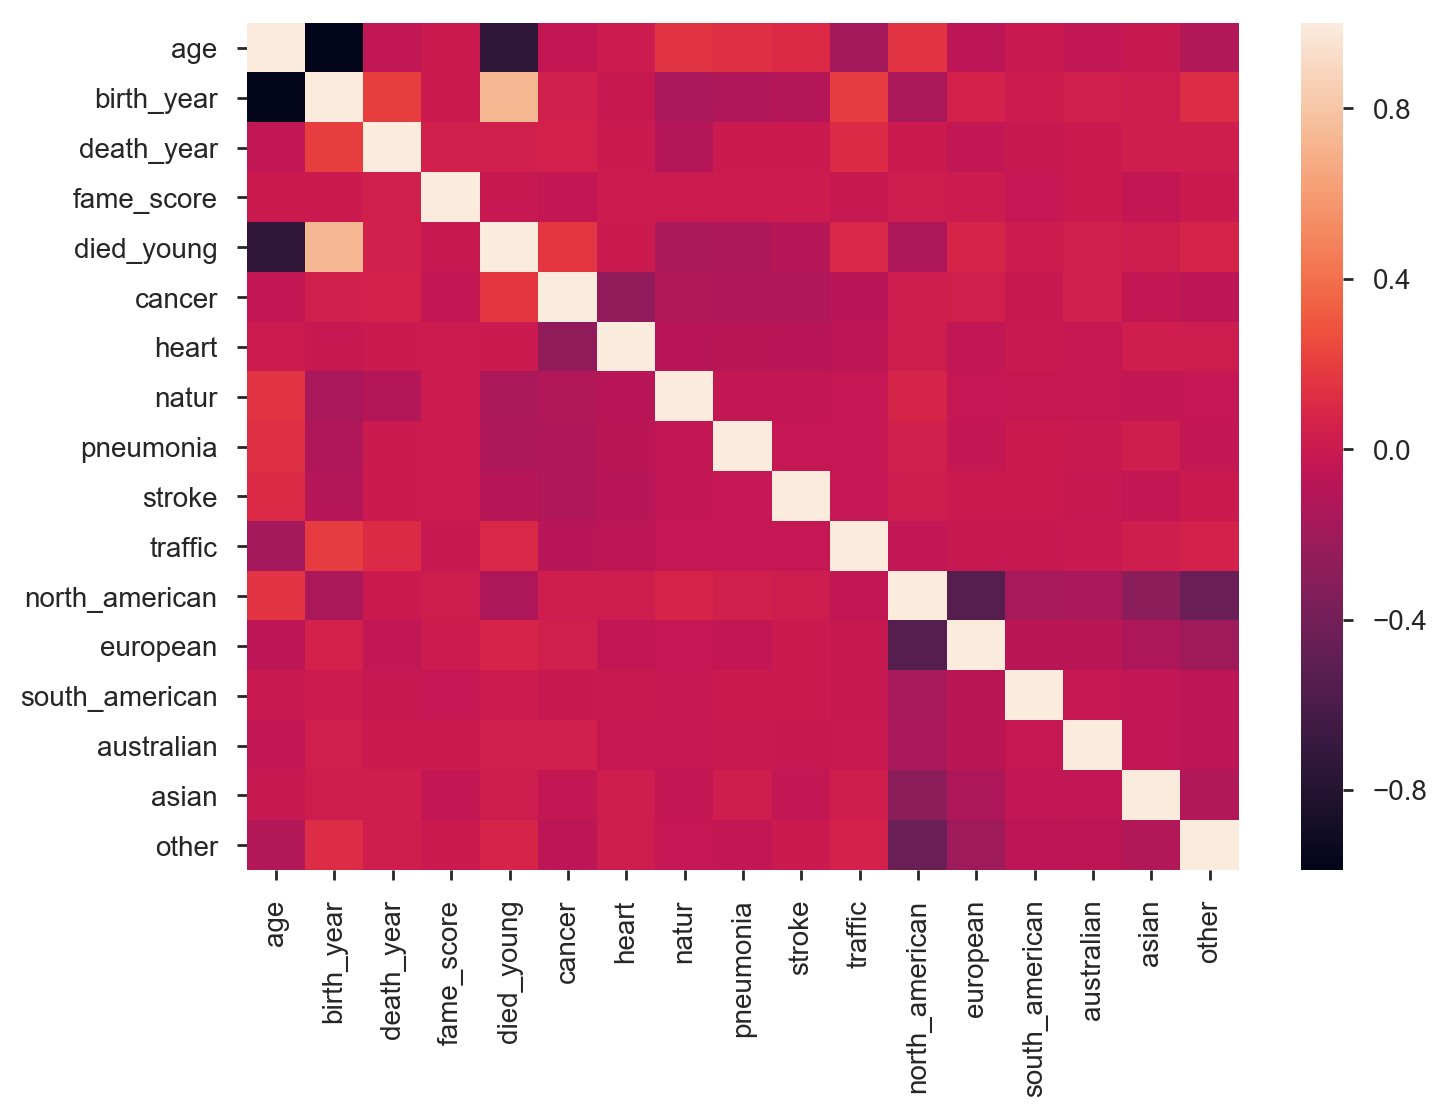

In [74]:
corr = df.corr()
sns.heatmap(corr, annot=False);

In [75]:
df.shape

(8375, 24)

In [76]:
df.describe(include='all')

,age,birth_year,cause_of_death,death_month,death_year,famous_for,name,nationality,fame_score,died_young,...,stroke,traffic,continent,north_american,european,south_american,australian,asian,other,season
count,8375.000000,8375.000000,8375,8375,8375.000000,8375,8375,8375,8375.000000,8375.000000,...,8375.000000,8375.000000,8375,8375.000000,8375.000000,8375.000000,8375.000000,8375.000000,8375.000000,8375
unique,NaN,NaN,1554,12,NaN,874,8351,215,NaN,NaN,...,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,4
top,NaN,NaN,cancer,January,NaN,politician,Dave Edwards,american,NaN,NaN,...,NaN,NaN,north_american,NaN,NaN,NaN,NaN,NaN,NaN,winter
freq,NaN,NaN,1055,757,NaN,1375,2,4063,NaN,NaN,...,NaN,NaN,4494,NaN,NaN,NaN,NaN,NaN,NaN,2145
mean,70.029612,1941.845373,NaN,NaN,2011.874985,NaN,NaN,NaN,11.801194,0.602388,...,0.044657,0.018507,NaN,0.536597,0.199881,0.023761,0.021970,0.070567,0.147224,NaN
std,17.702827,18.034964,NaN,NaN,2.788845,NaN,NaN,NaN,26.793450,0.489434,...,0.206561,0.134785,NaN,0.498689,0.399934,0.152313,0.146595,0.256116,0.354350,NaN
min,2.000000,1889.000000,NaN,NaN,2006.000000,NaN,NaN,NaN,1.000000,0.000000,...,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,60.000000,1928.000000,NaN,NaN,2010.000000,NaN,NaN,NaN,2.000000,0.000000,...,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,73.000000,1939.000000,NaN,NaN,2012.000000,NaN,NaN,NaN,5.000000,1.000000,...,0.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,83.000000,1952.000000,NaN,NaN,2014.000000,NaN,NaN,NaN,11.000000,1.000000,...,0.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


# START MODELING - RANDOM FORESTS

In [77]:
# LET'S TRY FAMOUS_FOR 

In [78]:
# create a count vectorizer for text column(s)
cvec = CountVectorizer(stop_words = 'english')

In [79]:
# target will be the died_young column
y = df['died_young']

In [80]:
# USE FAMOUS_FOR AS PREDICTOR 
X = df['famous_for']

X = pd.DataFrame(cvec.fit_transform(X).todense(),
            columns=cvec.get_feature_names())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [81]:
# FIT RANDOM FOREST MODEL FOR FAMOUS_FOR PREDICTOR 
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [82]:
# SCORE FOR TRAIN DATA ON FAMOUS_FOR 
rfc.score(X_train, y_train)

0.67263732514500174

In [83]:
# SCORE FOR TEST DATA ON FAMOUS_FOR 
rfc.score(X_test, y_test)

0.61679267807401517

In [84]:
# we need to get our models predictions based on the x_test data
predictions = rfc.predict(X_test)  
predictions

array([1, 1, 1, ..., 0, 0, 1])

In [85]:
print("\nClassification Report:\n",classification_report(y_test, predictions))

# What is this telling us? 
# Averaging about 62% accuracy - not very good.  


Classification Report:
              precision    recall  f1-score   support

          0       0.54      0.33      0.41      1014
          1       0.64      0.81      0.72      1499

avg / total       0.60      0.62      0.59      2513



In [86]:
#Now let's determine our AUC score and visualize our ROC curve

rfc_y_score = rfc.predict_proba(X_test)[:, 1] #<-- formats output as one long array
rfc_y_score

array([ 0.55448414,  0.53439299,  0.67481597, ...,  0.07357143,
        0.32013391,  0.79872853])

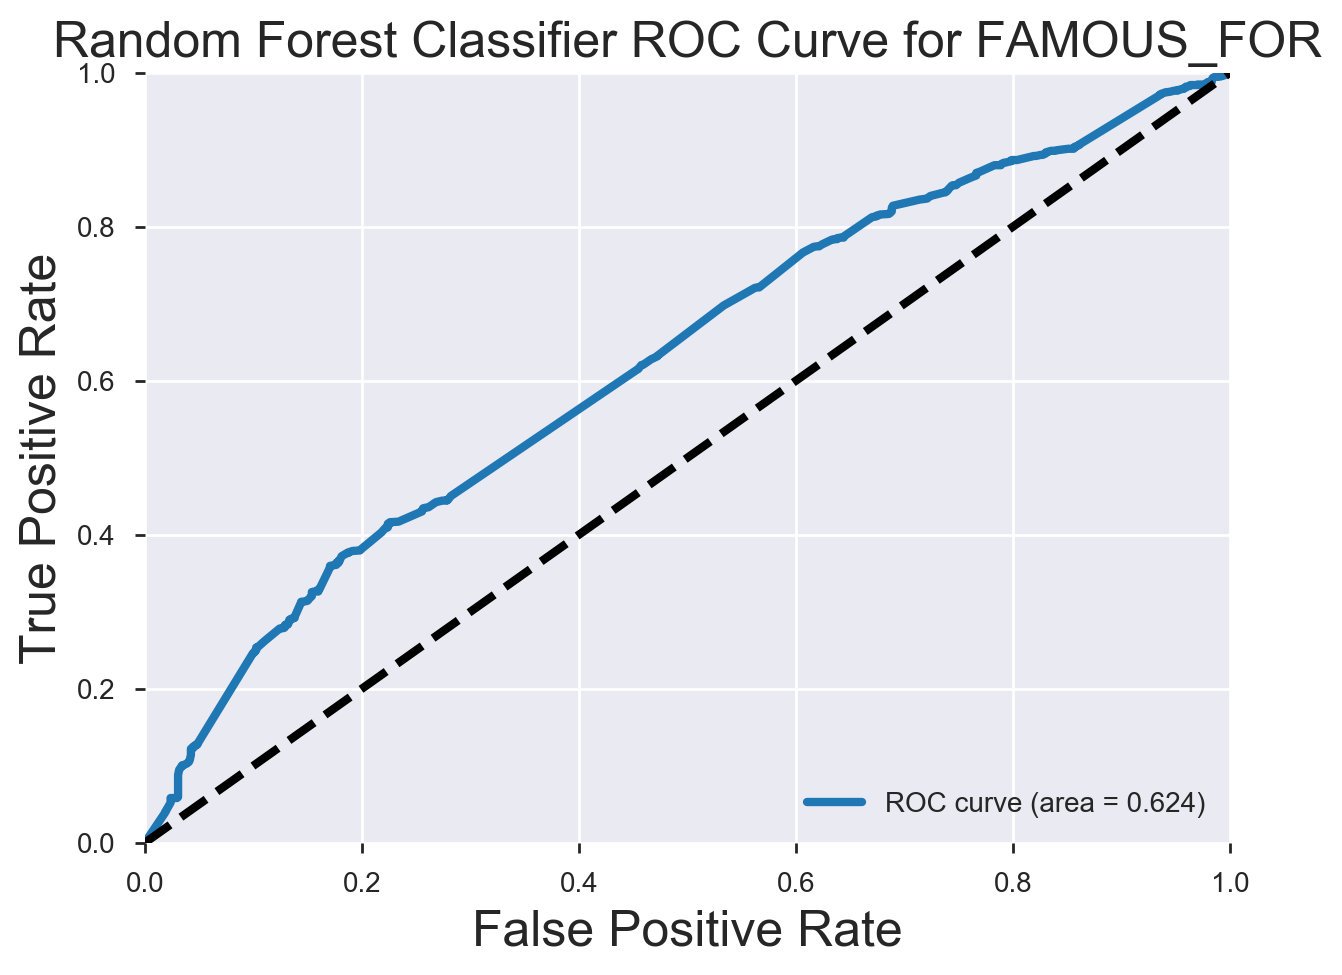

In [87]:
# Let's visualize the curve

rfc_FPR = dict()
rfc_TPR = dict()
rfc_ROC_AUC = dict()

rfc_FPR[1], rfc_TPR[1], _ = roc_curve(y_test, rfc_y_score)
rfc_ROC_AUC[1] = auc(rfc_FPR[1], rfc_TPR[1])

plt.figure(figsize=[7,5])
plt.plot(rfc_FPR[1], rfc_TPR[1], label='ROC curve (area = %0.3f)' % rfc_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Random Forest Classifier ROC Curve for FAMOUS_FOR', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [88]:
# #determine most important features/words in our model
rfc_feature_importances = pd.DataFrame(rfc.feature_importances_,
                                       index = X.columns,
                                       columns=['importance']).sort_values('importance',
                                       ascending=False)
print(rfc_feature_importances.head(10))
rfc_feature_importances.head(10).sum()


           importance
footbal      0.062663
musician     0.024399
singer       0.015216
drummer      0.011165
rock         0.010624
guitarist    0.009110
feder        0.008325
bassist      0.007890
rugbi        0.007735
judg         0.006605


importance    0.163731
dtype: float64

In [89]:
# LET'S TRY CAUSE_OF_DEATH

In [90]:
# create a count vectorizer for text column(s)
cvec = CountVectorizer(stop_words = 'english')

In [91]:
# target will be the died_young column
y = df['died_young']

In [92]:
# USE CAUSE_OF_DEATH AS PREDICTOR 
X = df['cause_of_death']

X = pd.DataFrame(cvec.fit_transform(X).todense(),
            columns=cvec.get_feature_names())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [93]:
# FIT RANDOM FOREST MODEL FOR CAUSE_OF_DEATH PREDICTOR 
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [94]:
# SCORE FOR TRAIN DATA ON CAUSE_OF_DEATH 
rfc.score(X_train, y_train)

0.78317980211531901

In [95]:
# SCORE FOR TEST DATA ON CAUSE_OF_DEATH 
rfc.score(X_test, y_test)

0.71030640668523681

In [96]:
# we need to get our models predictions based on the x_test data
predictions = rfc.predict(X_test)  
predictions

array([1, 1, 1, ..., 0, 1, 1])

In [97]:
print("\nClassification Report:\n",classification_report(y_test, predictions))

# What is this telling us? 
# Averaging about 72% accuracy - better than famous_for  


Classification Report:
              precision    recall  f1-score   support

          0       0.65      0.62      0.63      1014
          1       0.75      0.77      0.76      1499

avg / total       0.71      0.71      0.71      2513



In [98]:
#Now let's determine our AUC score and visualize our ROC curve

rfc_y_score = rfc.predict_proba(X_test)[:, 1] #<-- formats output as one long array
rfc_y_score

array([ 0.70884421,  0.88275738,  0.70884421, ...,  0.35180663,
        0.76614944,  0.76614944])

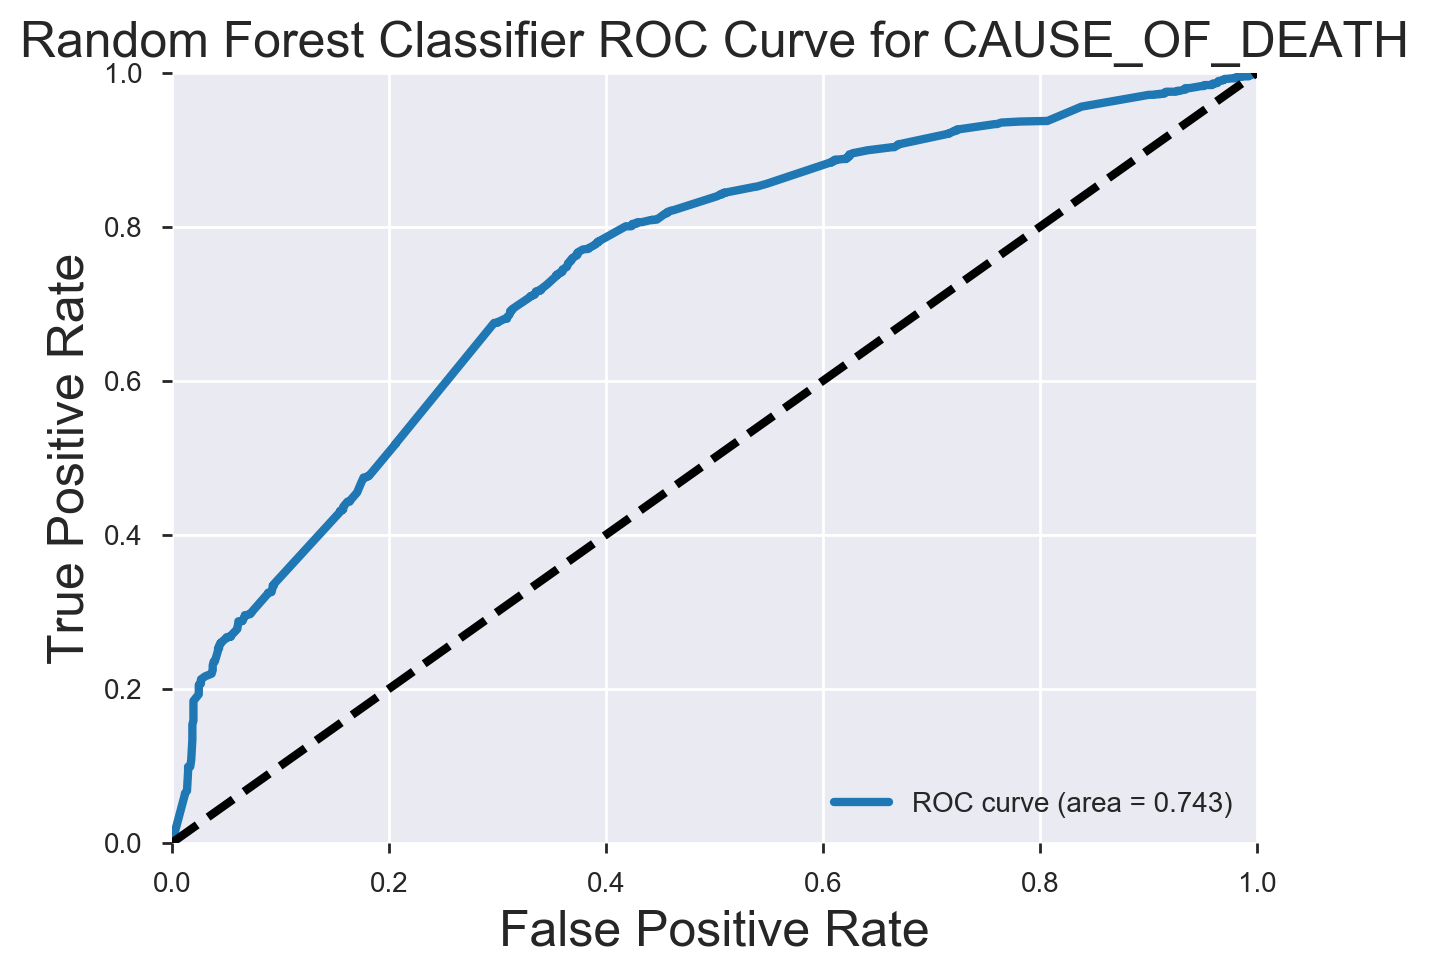

In [99]:
# Let's visualize the curve

rfc_FPR = dict()
rfc_TPR = dict()
rfc_ROC_AUC = dict()

rfc_FPR[1], rfc_TPR[1], _ = roc_curve(y_test, rfc_y_score)
rfc_ROC_AUC[1] = auc(rfc_FPR[1], rfc_TPR[1])

plt.figure(figsize=[7,5])
plt.plot(rfc_FPR[1], rfc_TPR[1], label='ROC curve (area = %0.3f)' % rfc_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Random Forest Classifier ROC Curve for CAUSE_OF_DEATH', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [100]:
# #determine most important features/words in our model
rfc_feature_importances = pd.DataFrame(rfc.feature_importances_,
                                       index = X.columns,
                                       columns=['importance']).sort_values('importance',
                                       ascending=False)
print(rfc_feature_importances.head(10))
rfc_feature_importances.head(10).sum()


           importance
pneumonia    0.046760
natur        0.035091
failur       0.034962
cancer       0.031222
caus         0.026835
diseas       0.023400
complic      0.020868
attack       0.020822
alzheimer    0.020496
shot         0.019942


importance    0.280397
dtype: float64

In [101]:
# LET'S TRY NATIONALITY

In [102]:
# create a count vectorizer for text column(s)
cvec = CountVectorizer(stop_words = 'english')

In [103]:
# target will be the died_young column
y = df['died_young']

In [104]:
# USE NATIONALITY AS PREDICTOR 
X = df['nationality']

X = pd.DataFrame(cvec.fit_transform(X).todense(),
            columns=cvec.get_feature_names())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [105]:
# FIT RANDOM FOREST MODEL FOR NATIONALITY PREDICTOR 
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [106]:
# SCORE FOR TRAIN DATA ON NATIONALITY 
rfc.score(X_train, y_train)

0.61173660866598434

In [107]:
# SCORE FOR TEST DATA ON NATIONALITY 
rfc.score(X_test, y_test)

0.58893752487067252

In [108]:
# we need to get our models predictions based on the x_test data
predictions = rfc.predict(X_test)  
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [109]:
print("\nClassification Report:\n",classification_report(y_test, predictions))

# What is this telling us? 
# Averaging about 53% accuracy - not good.   


Classification Report:
              precision    recall  f1-score   support

          0       0.37      0.03      0.05      1014
          1       0.60      0.97      0.74      1499

avg / total       0.50      0.59      0.46      2513



In [110]:
#Now let's determine our AUC score and visualize our ROC curve

rfc_y_score = rfc.predict_proba(X_test)[:, 1] #<-- formats output as one long array
rfc_y_score

array([ 0.52550047,  0.95      ,  0.52550047, ...,  0.52550047,
        0.52550047,  0.62769647])

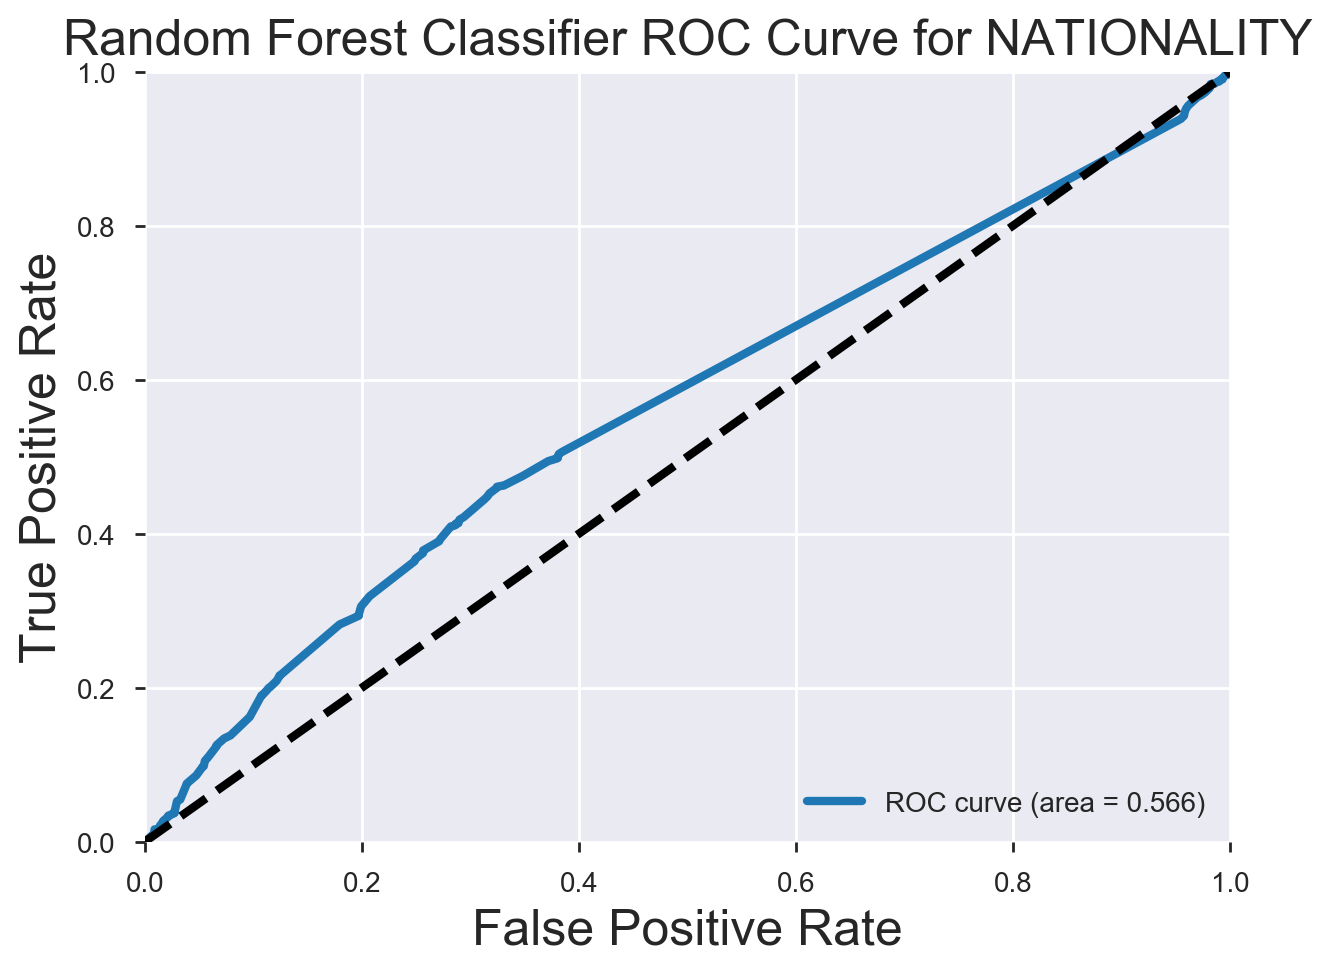

In [111]:
# Let's visualize the curve

rfc_FPR = dict()
rfc_TPR = dict()
rfc_ROC_AUC = dict()

rfc_FPR[1], rfc_TPR[1], _ = roc_curve(y_test, rfc_y_score)
rfc_ROC_AUC[1] = auc(rfc_FPR[1], rfc_TPR[1])

plt.figure(figsize=[7,5])
plt.plot(rfc_FPR[1], rfc_TPR[1], label='ROC curve (area = %0.3f)' % rfc_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Random Forest Classifier ROC Curve for NATIONALITY', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [112]:
# #determine most important features/words in our model
rfc_feature_importances = pd.DataFrame(rfc.feature_importances_,
                                       index = X.columns,
                                       columns=['importance']).sort_values('importance',
                                       ascending=False)
print(rfc_feature_importances.head(10))
rfc_feature_importances.head(10).sum()


             importance
american       0.209625
chilean        0.024482
british        0.022146
russian        0.020849
mexican        0.016017
canadian       0.015940
ukrainian      0.015446
english        0.015168
egyptian       0.013346
singaporean    0.013191


importance    0.36621
dtype: float64

In [113]:
# LET'S TRY CONTINENT

In [114]:
# create a count vectorizer for text column(s)
cvec = CountVectorizer(stop_words = 'english')

In [115]:
# target will be the died_young column
y = df['died_young']

In [116]:
# USE CONTINENT AS PREDICTOR 
X = df['continent']

X = pd.DataFrame(cvec.fit_transform(X).todense(),
            columns=cvec.get_feature_names())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [117]:
# FIT RANDOM FOREST MODEL FOR CONTINENT PREDICTOR 
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [118]:
# SCORE FOR TRAIN DATA ON CONTINENT 
rfc.score(X_train, y_train)

0.60491299897645856

In [119]:
# SCORE FOR TEST DATA ON CONTINENT 
rfc.score(X_test, y_test)

0.59649820931157982

In [120]:
# we need to get our models predictions based on the x_test data
predictions = rfc.predict(X_test)  
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [121]:
print("\nClassification Report:\n",classification_report(y_test, predictions))

# What is this telling us? 
# Averaging about 53% accuracy - not good.   


Classification Report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00      1014
          1       0.60      1.00      0.75      1499

avg / total       0.36      0.60      0.45      2513



C:\Users\CHIWLONG\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [122]:
#Now let's determine our AUC score and visualize our ROC curve

rfc_y_score = rfc.predict_proba(X_test)[:, 1] #<-- formats output as one long array
rfc_y_score

array([ 0.54077767,  0.6762751 ,  0.54077767, ...,  0.54077767,
        0.54077767,  0.6762751 ])

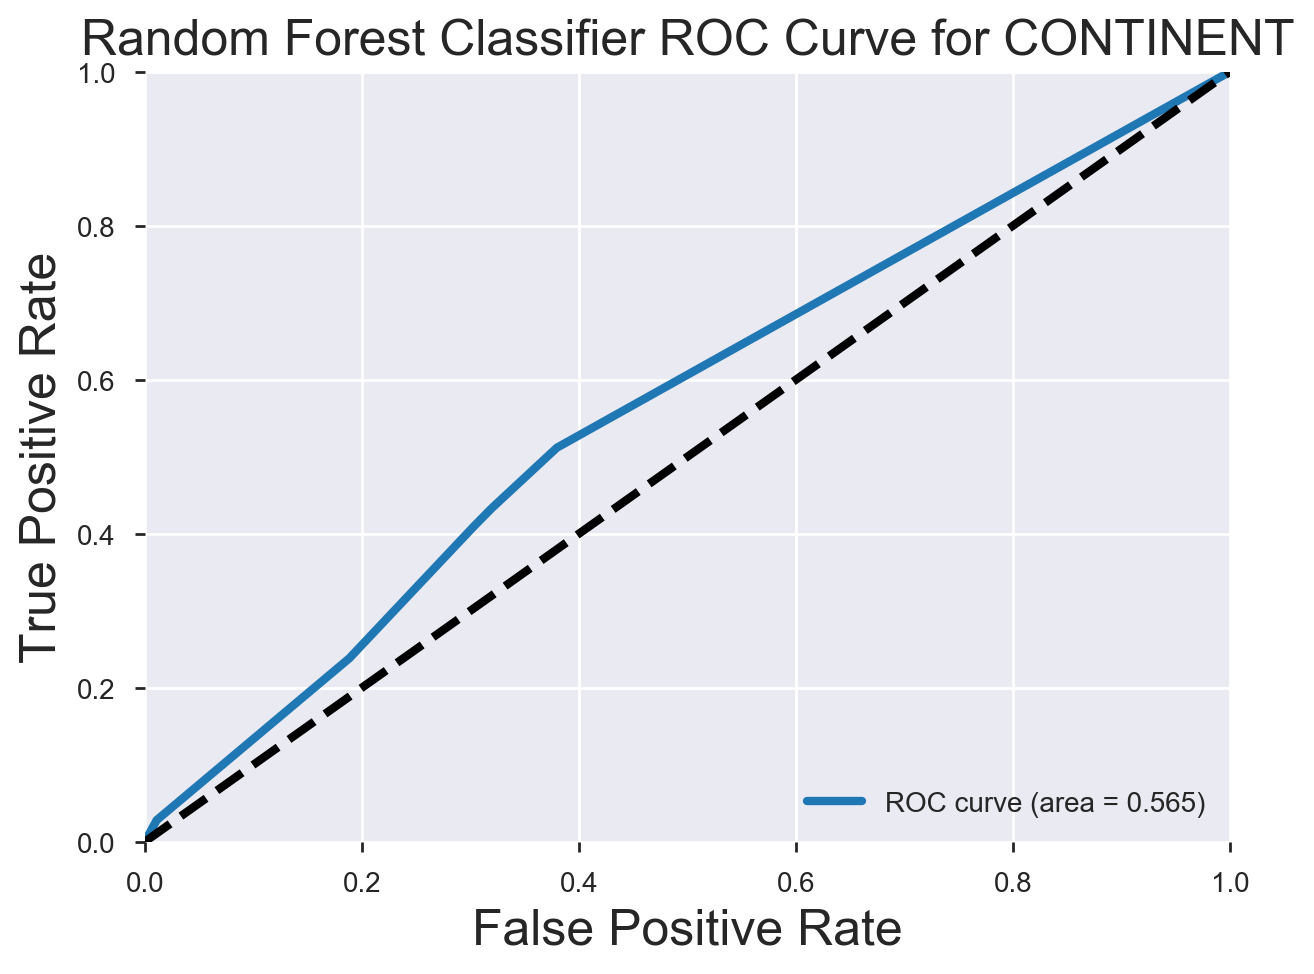

In [123]:
# Let's visualize the curve

rfc_FPR = dict()
rfc_TPR = dict()
rfc_ROC_AUC = dict()

rfc_FPR[1], rfc_TPR[1], _ = roc_curve(y_test, rfc_y_score)
rfc_ROC_AUC[1] = auc(rfc_FPR[1], rfc_TPR[1])

plt.figure(figsize=[7,5])
plt.plot(rfc_FPR[1], rfc_TPR[1], label='ROC curve (area = %0.3f)' % rfc_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Random Forest Classifier ROC Curve for CONTINENT', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [124]:
# #determine most important features/words in our model
rfc_feature_importances = pd.DataFrame(rfc.feature_importances_,
                                       index = X.columns,
                                       columns=['importance']).sort_values('importance',
                                       ascending=False)
print(rfc_feature_importances.head(10))
rfc_feature_importances.head(10).sum()


                importance
north_american    0.808643
european          0.109031
australian        0.046181
asian             0.025471
south_american    0.010675


importance    1.0
dtype: float64

In [125]:
# TRY FAME_SCORE? 

In [126]:
# create a count vectorizer for text column(s)
#cvec = CountVectorizer(stop_words = 'english')

In [127]:
# target will be the died_young column
y = df['died_young']

In [128]:
# USE FAME_SCORE AS PREDICTOR 
X = df['fame_score'].values.reshape(-1,1)

#X = pd.DataFrame(cvec.fit_transform(X).todense(),
            #columns=cvec.get_feature_names())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [129]:
# FIT RANDOM FOREST MODEL FOR FAME_SCORE PREDICTOR 
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [130]:
# SCORE FOR TRAIN DATA ON FAME_SCORE 
rfc.score(X_train, y_train)

0.61446605254179465

In [131]:
# SCORE FOR TEST DATA ON FAME_SCORE 
rfc.score(X_test, y_test)

0.59371269399124549

In [132]:
# we need to get our models predictions based on the x_test data
predictions = rfc.predict(X_test)  
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [133]:
print("\nClassification Report:\n",classification_report(y_test, predictions))

# What is this telling us? 
# Averaging about 53% accuracy - not good.   


Classification Report:
              precision    recall  f1-score   support

          0       0.45      0.03      0.06      1014
          1       0.60      0.98      0.74      1499

avg / total       0.54      0.59      0.46      2513



In [134]:
#Now let's determine our AUC score and visualize our ROC curve

rfc_y_score = rfc.predict_proba(X_test)[:, 1] #<-- formats output as one long array
rfc_y_score

array([ 0.61866725,  0.68575296,  0.63843716, ...,  0.59984582,
        0.57497095,  0.60670665])

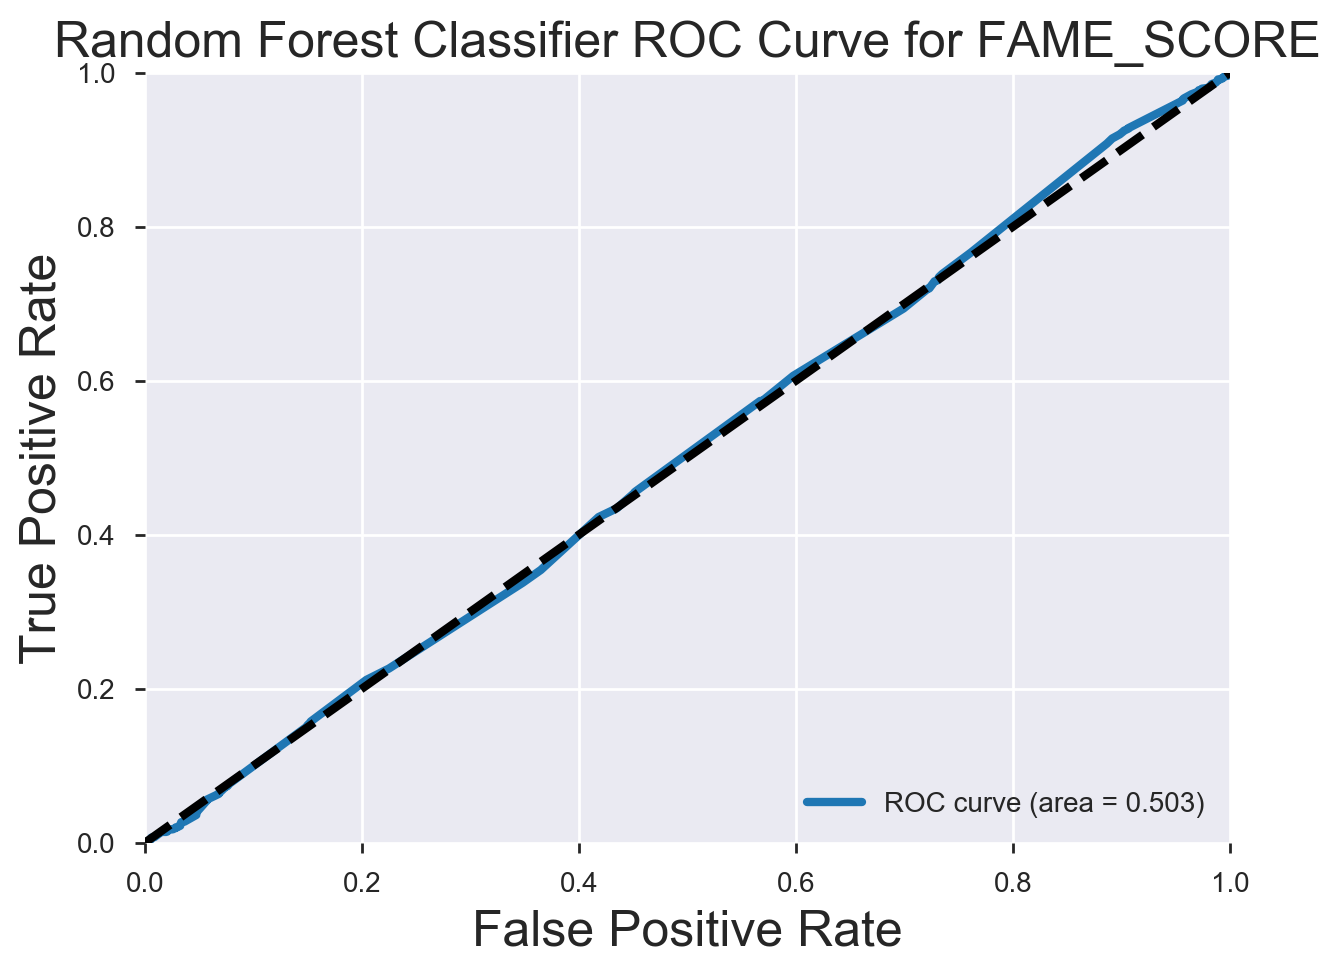

In [135]:
# Let's visualize the curve

rfc_FPR = dict()
rfc_TPR = dict()
rfc_ROC_AUC = dict()

rfc_FPR[1], rfc_TPR[1], _ = roc_curve(y_test, rfc_y_score)
rfc_ROC_AUC[1] = auc(rfc_FPR[1], rfc_TPR[1])

plt.figure(figsize=[7,5])
plt.plot(rfc_FPR[1], rfc_TPR[1], label='ROC curve (area = %0.3f)' % rfc_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Random Forest Classifier ROC Curve for FAME_SCORE', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [136]:
# TRY NORTH_AMERICAN?

In [137]:
# create a count vectorizer for text column(s)
#cvec = CountVectorizer(stop_words = 'english')

In [138]:
# target will be the died_young column
y = df['died_young']

In [139]:
# USE NORTH_AMERICAN AS PREDICTOR 
X = df['north_american'].values.reshape(-1,1)

#X = pd.DataFrame(cvec.fit_transform(X).todense(),
            #columns=cvec.get_feature_names())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [140]:
# FIT RANDOM FOREST MODEL FOR NORTH_AMERICAN PREDICTOR 
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [141]:
# SCORE FOR TRAIN DATA ON NORTH_AMERICAN 
rfc.score(X_train, y_train)

0.60491299897645856

In [142]:
# SCORE FOR TEST DATA ON NORTH_AMERICAN 
rfc.score(X_test, y_test)

0.59649820931157982

In [143]:
# we need to get our models predictions based on the x_test data
predictions = rfc.predict(X_test)  
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [144]:
print("\nClassification Report:\n",classification_report(y_test, predictions))

# What is this telling us? 
# Averaging about 53% accuracy - not good.   


Classification Report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00      1014
          1       0.60      1.00      0.75      1499

avg / total       0.36      0.60      0.45      2513



C:\Users\CHIWLONG\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [145]:
#Now let's determine our AUC score and visualize our ROC curve

rfc_y_score = rfc.predict_proba(X_test)[:, 1] #<-- formats output as one long array
rfc_y_score

array([ 0.54077767,  0.6716332 ,  0.54077767, ...,  0.54077767,
        0.54077767,  0.6716332 ])

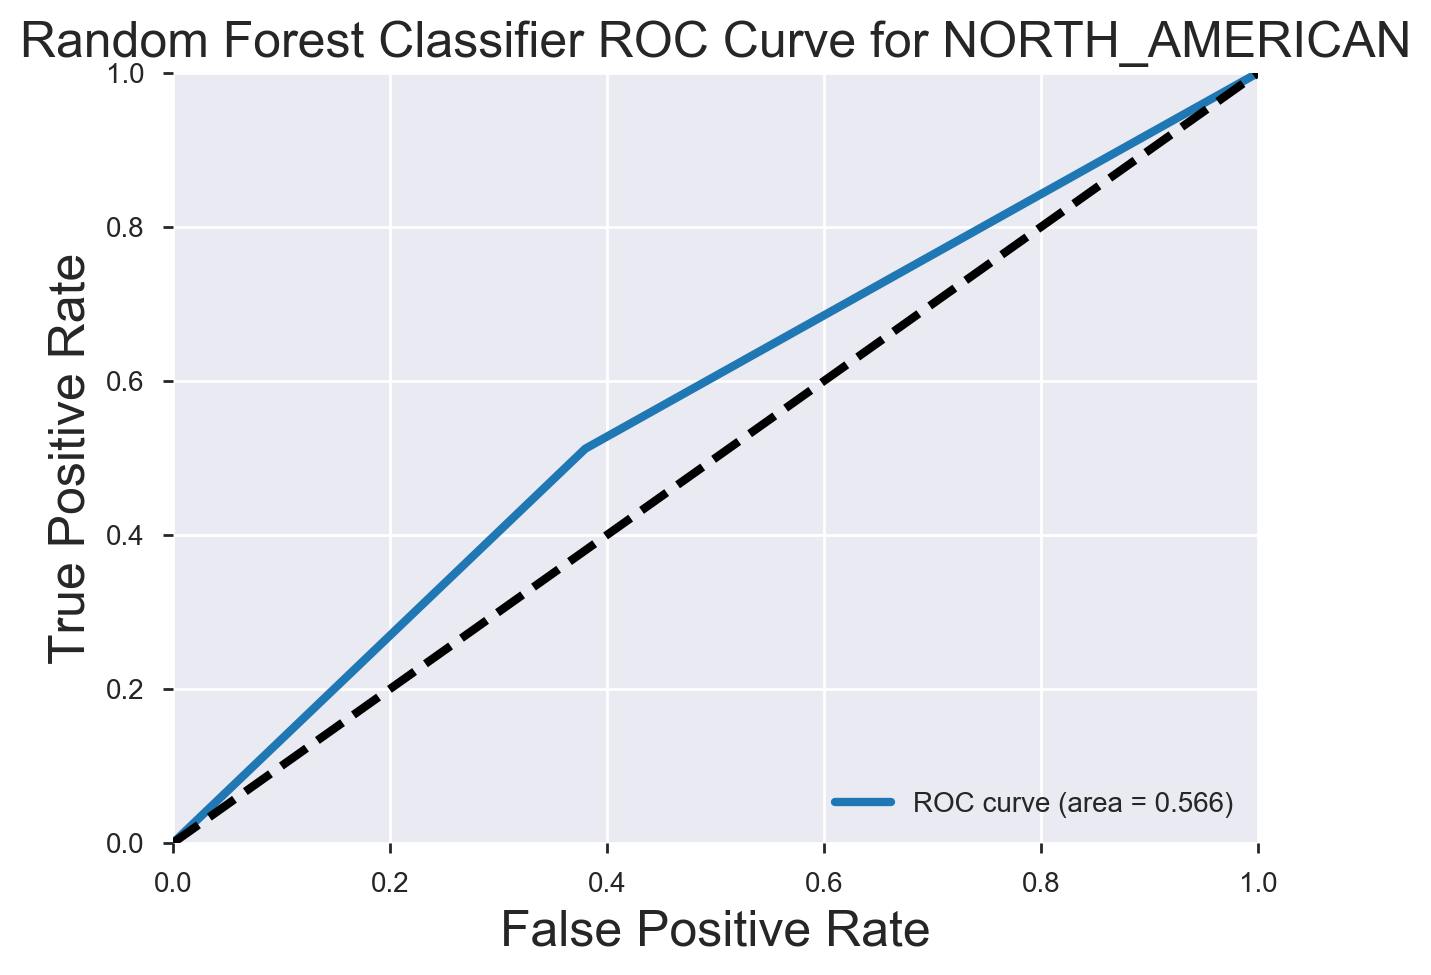

In [146]:
# Let's visualize the curve

rfc_FPR = dict()
rfc_TPR = dict()
rfc_ROC_AUC = dict()

rfc_FPR[1], rfc_TPR[1], _ = roc_curve(y_test, rfc_y_score)
rfc_ROC_AUC[1] = auc(rfc_FPR[1], rfc_TPR[1])

plt.figure(figsize=[7,5])
plt.plot(rfc_FPR[1], rfc_TPR[1], label='ROC curve (area = %0.3f)' % rfc_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Random Forest Classifier ROC Curve for NORTH_AMERICAN', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [147]:
# NOW LET'S TRY BIRTH_YEAR

In [148]:
# create a count vectorizer for text column(s)
#cvec = CountVectorizer(stop_words = 'english')

In [149]:
# target will be the died_young column
y = df['died_young']

In [150]:
# USE BIRTH_YEAR AS PREDICTOR 
X = df['birth_year'].values.reshape(-1,1)

#X = pd.DataFrame(cvec.fit_transform(X).todense(),
            #columns=cvec.get_feature_names())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [151]:
# FIT RANDOM FOREST MODEL FOR BIRTH_YEAR PREDICTOR 
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [152]:
# SCORE FOR TRAIN DATA ON BIRTH_YEAR 
rfc.score(X_train, y_train)

0.94916410781303306

In [153]:
# SCORE FOR TEST DATA ON BIRTH_YEAR 
rfc.score(X_test, y_test)

0.94787107043374452

In [154]:
# we need to get our models predictions based on the x_test data
predictions = rfc.predict(X_test)  
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [155]:
print("\nClassification Report:\n",classification_report(y_test, predictions))

# What is this telling us? 
# Averaging about 53% accuracy - not good.   


Classification Report:
              precision    recall  f1-score   support

          0       0.93      0.94      0.94      1014
          1       0.96      0.95      0.96      1499

avg / total       0.95      0.95      0.95      2513



In [156]:
#Now let's determine our AUC score and visualize our ROC curve

rfc_y_score = rfc.predict_proba(X_test)[:, 1] #<-- formats output as one long array
rfc_y_score

array([ 1.        ,  1.        ,  1.        , ...,  0.90791742,
        1.        ,  1.        ])

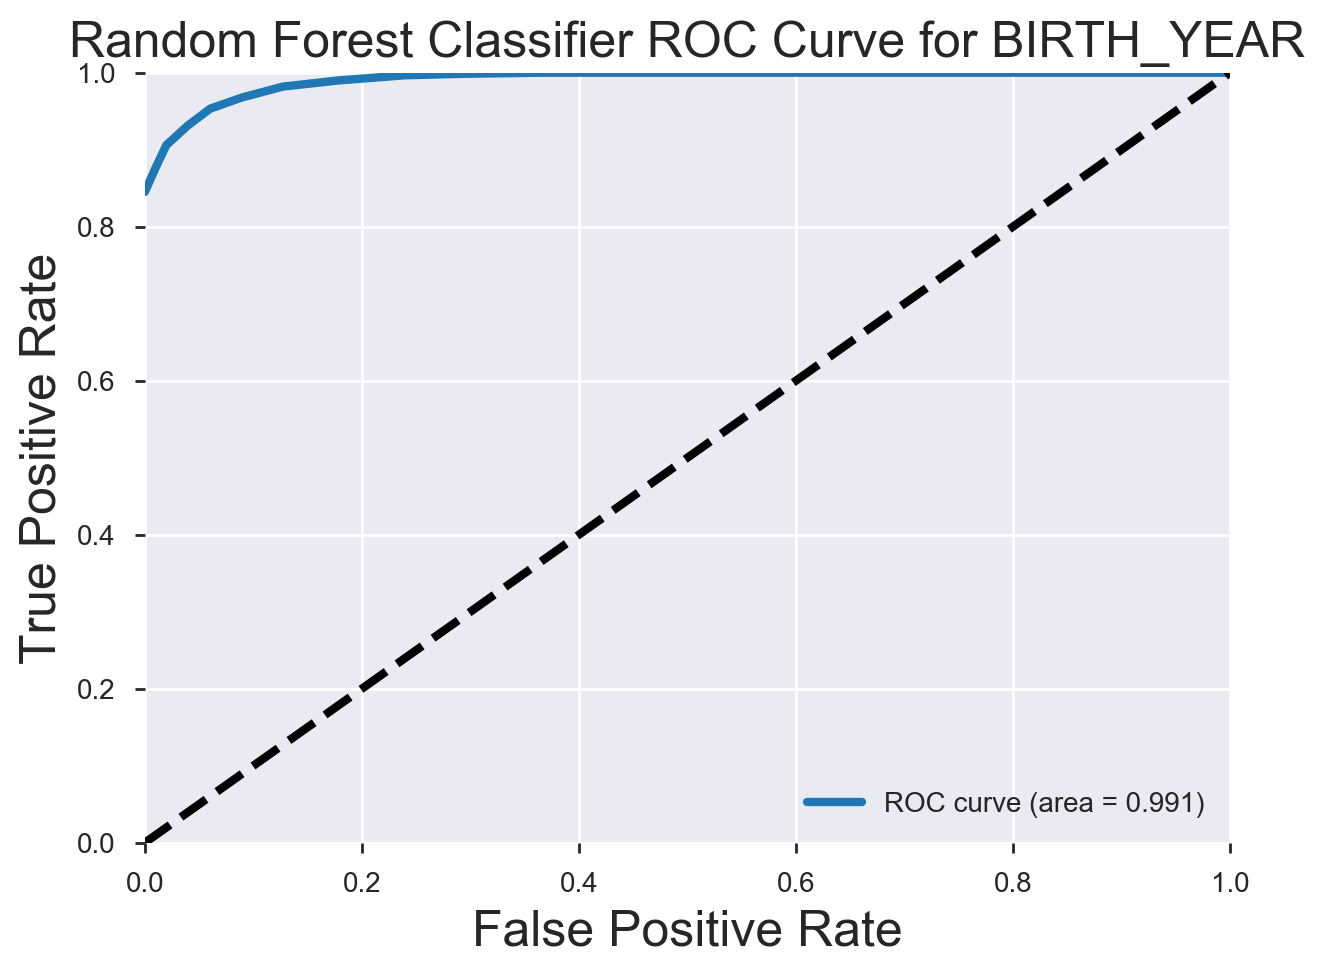

In [157]:
# Let's visualize the curve

rfc_FPR = dict()
rfc_TPR = dict()
rfc_ROC_AUC = dict()

rfc_FPR[1], rfc_TPR[1], _ = roc_curve(y_test, rfc_y_score)
rfc_ROC_AUC[1] = auc(rfc_FPR[1], rfc_TPR[1])

plt.figure(figsize=[7,5])
plt.plot(rfc_FPR[1], rfc_TPR[1], label='ROC curve (area = %0.3f)' % rfc_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Random Forest Classifier ROC Curve for BIRTH_YEAR', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [158]:
df[df.died_young == 1].birth_year.value_counts()

1944    196
1941    181
1945    175
1947    175
1940    172
1943    167
1946    166
1938    166
1942    161
1939    161
1948    156
1937    152
1949    144
1950    134
1952    127
1936    125
1951    115
1953    108
1935    106
1956    104
1955    103
1954     95
1957     91
1959     81
1962     81
1958     80
1964     79
1961     76
1960     76
1934     75
       ... 
1931     28
1978     27
1987     27
1982     26
1980     26
1977     25
1988     24
1985     21
1989     19
1930     18
1991     17
1990     15
1993     14
1992     10
1994      9
1995      9
1929      8
1996      7
1997      5
2005      3
2000      3
2008      3
2004      2
2001      2
1998      2
2006      2
1999      2
2009      1
2002      1
2010      1
Name: birth_year, Length: 80, dtype: int64

# LET'S TRY TUNING SOME PARAMETERS ON THE BETTER MODELS

In [159]:
# USE CAUSE_OF_DEATH AS PREDICTOR 
X = df['cause_of_death']

X = pd.DataFrame(cvec.fit_transform(X).todense(),
            columns=cvec.get_feature_names())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [160]:
%%time
# Randomized Search
rfc_parameters = {
    'n_estimators':[2,4,6,8,12,12,14,16,18,20],
    'criterion':['gini','entropy'], 
    'min_samples_leaf':[1,2,3,4,5], 
    'n_jobs':[-1] 
}

rfc_model = RandomForestClassifier()
rfc_randomsearcher = RandomizedSearchCV(rfc_model, rfc_parameters, scoring='accuracy', cv=5)
rfc_randomsearcher.fit(X_train, y_train)

Wall time: 22.8 s


In [161]:
print('RandomizedSearch')
print(rfc_randomsearcher.best_params_)
print(rfc_randomsearcher.best_score_)
print(rfc_randomsearcher.best_estimator_)

RandomizedSearch
{'n_jobs': -1, 'n_estimators': 18, 'min_samples_leaf': 1, 'criterion': 'entropy'}
0.715455475947
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=18, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [162]:
%%time
# Grid Search
rfc_parameters = {
    'n_estimators':[2,4,6,8,12,12,14,16,18,20],
    'criterion':['gini','entropy'], 
    'min_samples_leaf':[1,2,3,4,5], 
    'n_jobs':[-1] 
}

rfc_model = RandomForestClassifier()
rfc_gridsearcher = GridSearchCV(rfc_model, rfc_parameters, scoring='accuracy', cv=5)
rfc_gridsearcher.fit(X_train, y_train)

Wall time: 3min 50s


In [163]:
print('GridSearch')
print(rfc_gridsearcher.best_params_)
print(rfc_gridsearcher.best_score_)
print(rfc_gridsearcher.best_estimator_)

GridSearch
{'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 14, 'n_jobs': -1}
0.719208461276
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=14, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [164]:
# run again with best etimator
# FIT RANDOM FOREST MODEL FOR CAUSE_OF_DEATH PREDICTOR 
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=12, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=12, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [165]:
# SCORE FOR TRAIN DATA ON CAUSE_OF_DEATH 
rfc.score(X_train, y_train)

0.78454452405322417

In [166]:
# we need to get our models predictions based on the x_test data
predictions = rfc.predict(X_test)  
predictions

array([1, 1, 1, ..., 0, 1, 1])

In [167]:
print("\nClassification Report:\n",classification_report(y_test, predictions))

# What is this telling us? 
# Averaging about 72% accuracy - better than famous_for  


Classification Report:
              precision    recall  f1-score   support

          0       0.64      0.61      0.62      1014
          1       0.74      0.77      0.76      1499

avg / total       0.70      0.70      0.70      2513



In [168]:
#Now let's determine our AUC score and visualize our ROC curve

rfc_y_score = rfc.predict_proba(X_test)[:, 1] #<-- formats output as one long array
rfc_y_score

array([ 0.71002943,  0.81164854,  0.71002943, ...,  0.32703449,
        0.77430004,  0.77430004])

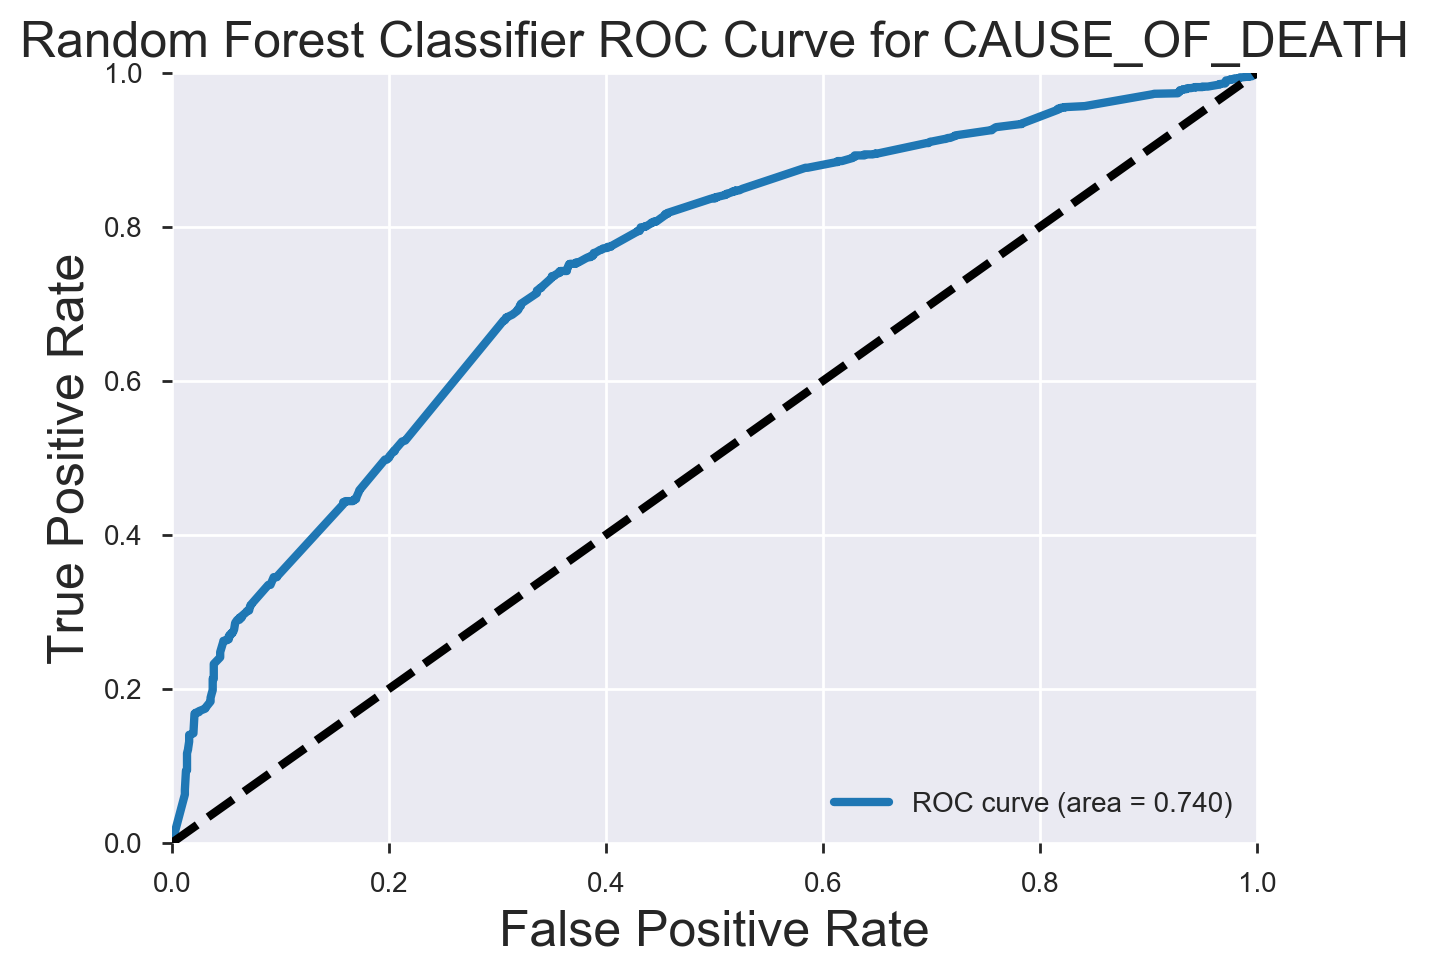

In [169]:
# Let's visualize the curve

rfc_FPR = dict()
rfc_TPR = dict()
rfc_ROC_AUC = dict()

rfc_FPR[1], rfc_TPR[1], _ = roc_curve(y_test, rfc_y_score)
rfc_ROC_AUC[1] = auc(rfc_FPR[1], rfc_TPR[1])

plt.figure(figsize=[7,5])
plt.plot(rfc_FPR[1], rfc_TPR[1], label='ROC curve (area = %0.3f)' % rfc_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Random Forest Classifier ROC Curve for CAUSE_OF_DEATH', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [170]:
# #determine most important features/words in our model
rfc_feature_importances = pd.DataFrame(rfc.feature_importances_,
                                       index = X.columns,
                                       columns=['importance']).sort_values('importance',
                                       ascending=False)
print(rfc_feature_importances.head(10))
rfc_feature_importances.head(10).sum()


           importance
natur        0.041499
pneumonia    0.036928
cancer       0.033690
failur       0.029961
shot         0.024351
complic      0.021963
alzheimer    0.019282
attack       0.018855
collis       0.017835
suicid       0.017166


importance    0.26153
dtype: float64

In [171]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    
    # Fit the model:
    model.fit(X_train, y_train)
    
    # Predict with the model:
    y_pred = model.predict(X_test)
    
    # Generate a confusion matrix:
    CM = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    # Assign true negatives, true positives, false negatives, and false positives:
    TN = CM[0][0]
    TP = CM[1][1]
    FN = CM[1][0]
    FP = CM[0][1]
    
    # Calculate metrics:
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    
    # Reuturn a list:
    return([CM, 
            'accuracy: ' + str(accuracy), 
            'sensitivity: ' + str(sensitivity), 
            'specificity: ' + str(specificity)])

In [172]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=12, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [173]:
model = RandomForestClassifier()

In [174]:
evaluate_model(model, X_train, X_test, y_train, y_test)

[array([[ 610,  404],
        [ 343, 1156]], dtype=int64),
 'accuracy: 0.702745722244',
 'sensitivity: 0.771180787191',
 'specificity: 0.60157790927']

In [175]:
model = LogisticRegression()

In [176]:
evaluate_model(model, X_train, X_test, y_train, y_test)

[array([[ 568,  446],
        [ 288, 1211]], dtype=int64),
 'accuracy: 0.707918822125',
 'sensitivity: 0.80787191461',
 'specificity: 0.560157790927']

In [177]:
model = KNeighborsClassifier()

In [178]:
evaluate_model(model, X_train, X_test, y_train, y_test)

[array([[ 584,  430],
        [ 438, 1061]], dtype=int64),
 'accuracy: 0.654596100279',
 'sensitivity: 0.707805203469',
 'specificity: 0.575936883629']

In [179]:
model = GaussianNB()

In [180]:
evaluate_model(model, X_train, X_test, y_train, y_test)

[array([[  96,  918],
        [  42, 1457]], dtype=int64),
 'accuracy: 0.617986470354',
 'sensitivity: 0.971981320881',
 'specificity: 0.094674556213']

In [181]:
model = BernoulliNB()

In [182]:
evaluate_model(model, X_train, X_test, y_train, y_test)

[array([[ 619,  395],
        [ 325, 1174]], dtype=int64),
 'accuracy: 0.713489852766',
 'sensitivity: 0.783188792528',
 'specificity: 0.610453648915']

In [183]:
model = MultinomialNB()

In [184]:
evaluate_model(model, X_train, X_test, y_train, y_test)

[array([[ 615,  399],
        [ 319, 1180]], dtype=int64),
 'accuracy: 0.714285714286',
 'sensitivity: 0.787191460974',
 'specificity: 0.60650887574']

In [185]:
# MultinomialNB() performed best without any tuning - let's try tuning it

In [186]:
%%time
# Grid Search
mnb_parameters = {
    'alpha':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    'fit_prior':[True, False]
}

mnb_model = MultinomialNB()
mnb_gridsearcher = GridSearchCV(mnb_model, mnb_parameters, n_jobs=-1, scoring='accuracy', cv=5)
mnb_gridsearcher.fit(X_train, y_train)

Wall time: 23.1 s


In [187]:
print('GridSearch')
print(mnb_gridsearcher.best_params_)
print(mnb_gridsearcher.best_score_)
print(mnb_gridsearcher.best_estimator_)

GridSearch
{'alpha': 0.5, 'fit_prior': True}
0.717673149096
MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)


In [194]:
# run again with best etimator
# FIT MNB MODEL FOR CAUSE_OF_DEATH PREDICTOR 
mnb = MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

mnb.fit(X_train, y_train)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

In [195]:
# SCORE FOR TRAIN DATA ON CAUSE_OF_DEATH 
mnb.score(X_train, y_train)

0.75503241214602523

In [196]:
# we need to get our models predictions based on the x_test data
predictions = mnb.predict(X_test)  
predictions

array([1, 1, 1, ..., 0, 1, 1])

In [197]:
print("\nClassification Report:\n",classification_report(y_test, predictions))

# What is this telling us? 
# Averaging about 73% accuracy - not bad  


Classification Report:
              precision    recall  f1-score   support

          0       0.66      0.61      0.63      1014
          1       0.75      0.79      0.77      1499

avg / total       0.71      0.72      0.71      2513



In [198]:
#Now let's determine our AUC score and visualize our ROC curve

mnb_y_score = mnb.predict_proba(X_test)[:, 1] #<-- formats output as one long array
mnb_y_score

array([ 0.75419776,  0.94153357,  0.75419776, ...,  0.25838576,
        0.81952978,  0.81952978])

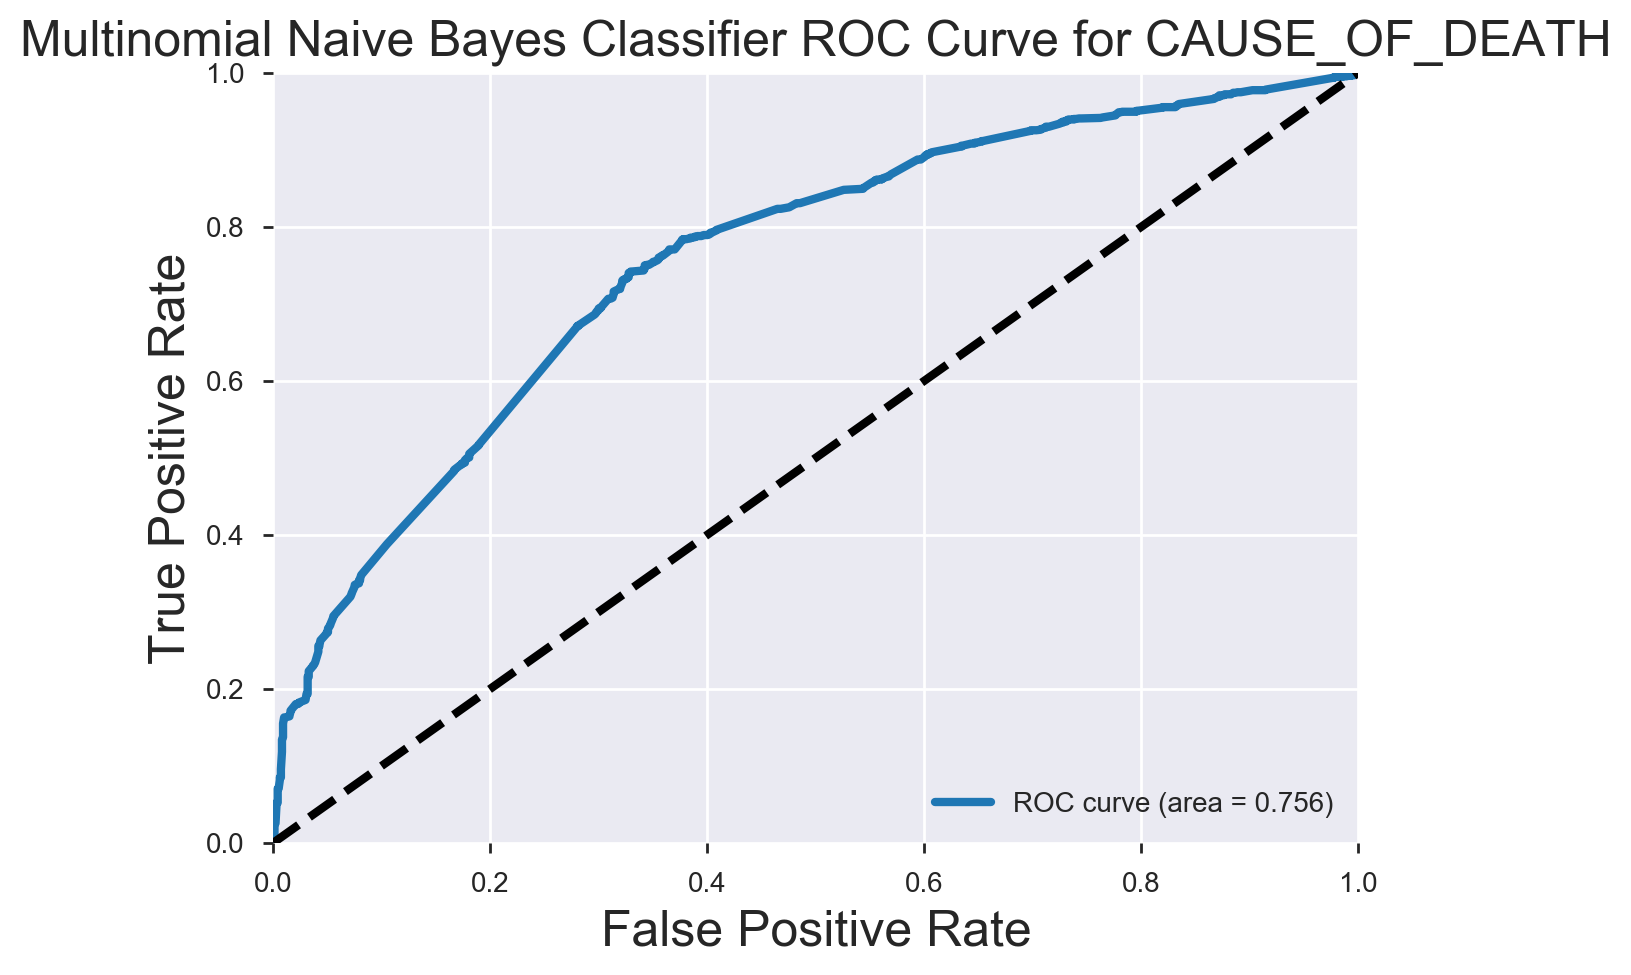

In [199]:
# Let's visualize the curve

mnb_FPR = dict()
mnb_TPR = dict()
mnb_ROC_AUC = dict()

mnb_FPR[1], mnb_TPR[1], _ = roc_curve(y_test, mnb_y_score)
mnb_ROC_AUC[1] = auc(mnb_FPR[1], mnb_TPR[1])

plt.figure(figsize=[7,5])
plt.plot(mnb_FPR[1], mnb_TPR[1], label='ROC curve (area = %0.3f)' % mnb_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Multinomial Naive Bayes Classifier ROC Curve for CAUSE_OF_DEATH', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [ ]:
# NEEDED TO GET WHAT I HAVE IN BEFORE THE DEADLINE. 
# MORE TO COME... 